In [ ]:
#%%

# MA Cross Backtesting on 1H BTC with following trade costs and timeframes
# - Slippage is 0.5BPS
# - Taker fee is 0.05%
# - Initial capital is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe is 1H
# 

In [ ]:
#%%

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [ ]:
#%%

df_ = pd.read_csv("./data/BTCUSDT/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)

hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df['Price'] = df['Open'].shift(-1)
df.dropna(inplace=True)

df

,Open,High,Low,Close,Volume,Price
date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,4308.83
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,4315.32
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691,4324.35
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249,4333.32
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,4360.69
...,...,...,...,...,...,...
2023-12-31 18:00:00,42616.24,42719.80,42538.37,42656.70,682.996910,42656.69
2023-12-31 19:00:00,42656.69,42695.44,42586.91,42619.04,703.557910,42619.04
2023-12-31 20:00:00,42619.04,42680.36,42504.56,42558.01,1015.140350,42558.02


<Axes: xlabel='date'>

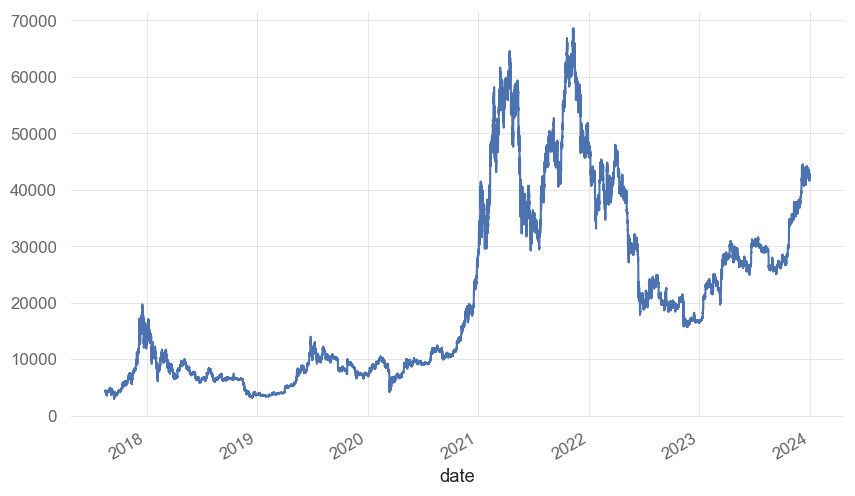

In [ ]:
#%%

df['Close'].plot()

In [ ]:
#%%

df.dropna(inplace=True)

In [ ]:
#%%

# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [ ]:
#%%

df['Signal'].value_counts()

Signal
 0    54393
 1      660
-1      659
Name: count, dtype: int64

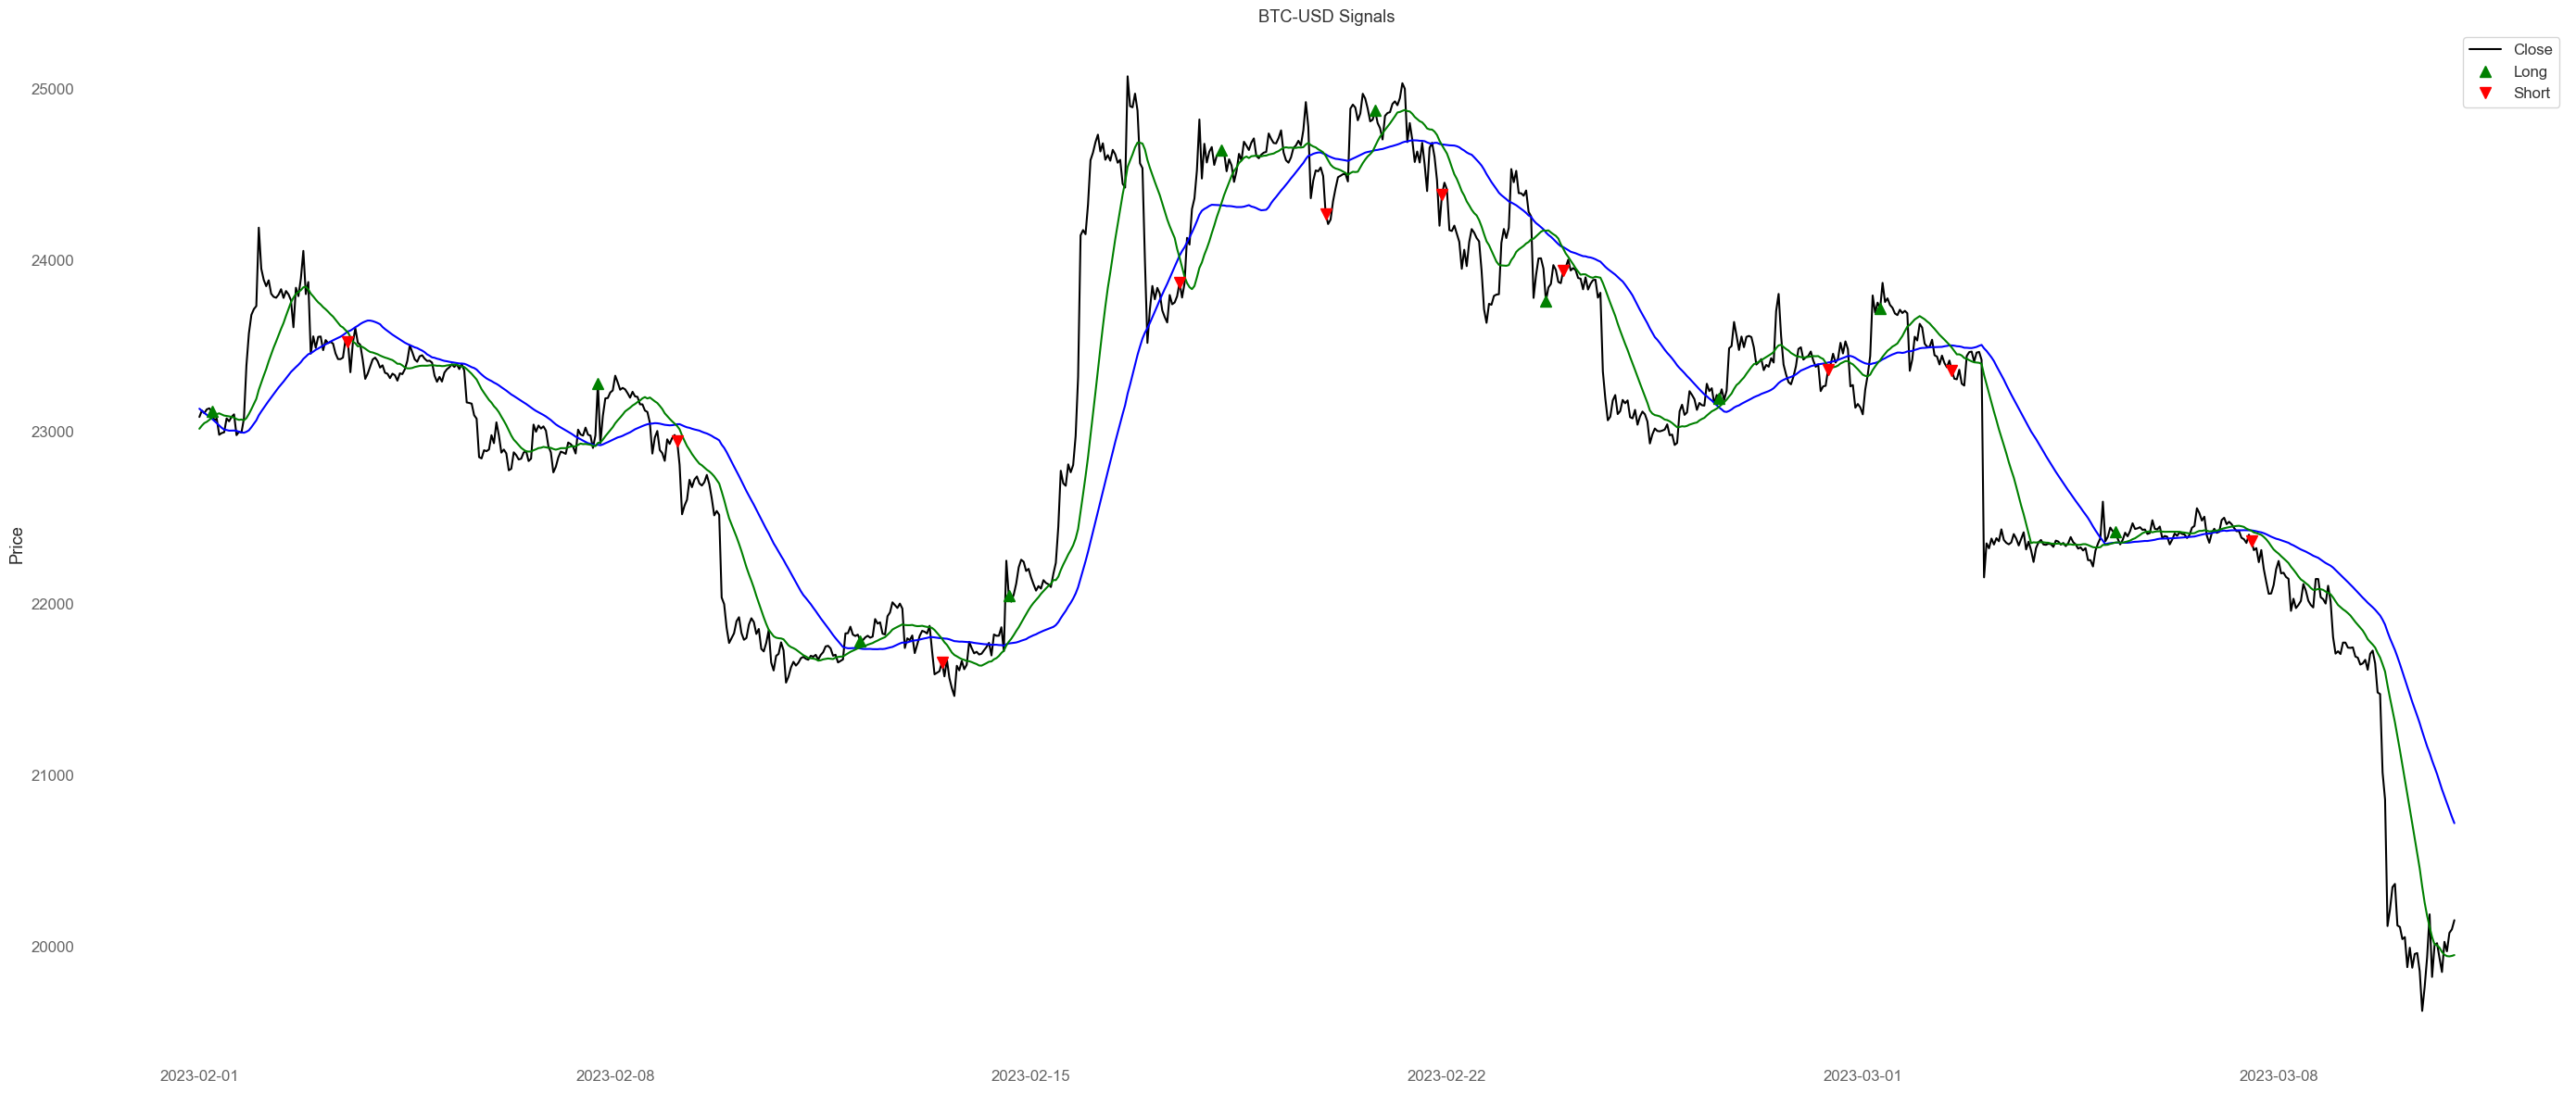

In [ ]:
#%%

plot_df = df["2023-02-01":"2023-03-10"]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [ ]:
#%%

# Position tracking
position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Price'] 
            pct_change     = (exit_price - entry_price) / entry_price
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change, position))
        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Price']
        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Price']
        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'Return', 'Position'])
position_df = position_df.set_index(pd.DatetimeIndex(position_df['EntryTime']))

position_df

,EntryTime,ExitTime,EntryPrice,ExitPrice,Return,Position
EntryTime,,,,,,
2017-08-20 13:00:00,2017-08-20 13:00:00,2017-08-20 14:00:00,4063.35,4096.32,0.008114,1.0
2017-08-21 12:00:00,2017-08-21 12:00:00,2017-08-21 13:00:00,4000.00,3914.59,-0.021352,-1.0
2017-08-23 03:00:00,2017-08-23 03:00:00,2017-08-23 04:00:00,4084.54,4084.00,-0.000132,1.0
2017-08-26 14:00:00,2017-08-26 14:00:00,2017-08-26 15:00:00,4274.00,4275.00,0.000234,-1.0
2017-08-27 11:00:00,2017-08-27 11:00:00,2017-08-27 12:00:00,4323.37,4314.11,-0.002142,1.0
...,...,...,...,...,...,...
2023-12-26 04:00:00,2023-12-26 04:00:00,2023-12-26 05:00:00,43450.01,42764.85,-0.015769,1.0
2023-12-26 08:00:00,2023-12-26 08:00:00,2023-12-26 09:00:00,42706.41,42408.91,-0.006966,-1.0
2023-12-27 21:00:00,2023-12-27 21:00:00,2023-12-27 22:00:00,43366.20,43323.81,-0.000977,1.0


<Axes: xlabel='EntryTime'>

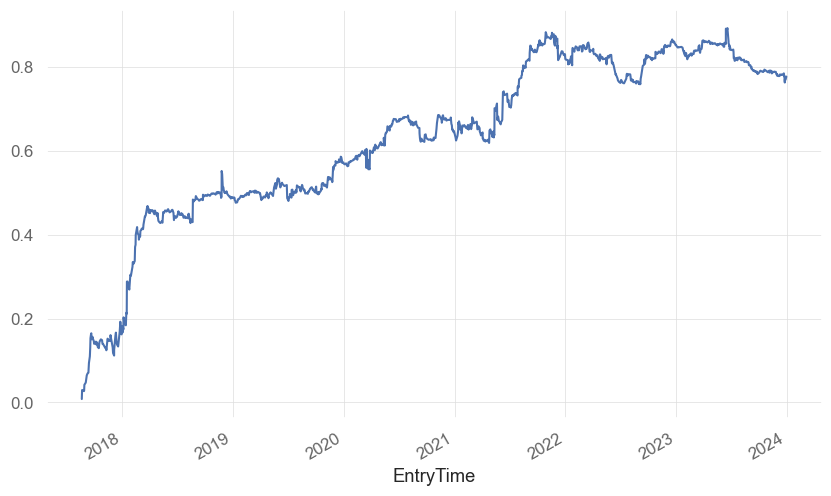

In [ ]:
#%%

position_df['StrategyReturn'] = position_df['Return'] * position_df['Position']
position_df['StrategyCumsum'] = position_df['StrategyReturn'].cumsum()

# Naive cumulative sum
position_df['StrategyCumsum'].plot()

In [ ]:
#%%

# Cost adjustments

position_df['LogReturn'] = (1+position_df['StrategyReturn']).apply(np.log)

slippage_pct  = 0.005 # 0.5BPS 
taker_fee_pct = 0.05  # Binance taker fee is 0.05%
transaction_cost_log = np.log(1-slippage_pct/100.0) + np.log(1-taker_fee_pct/100.0)
position_df['AdjustedLogReturn'] = position_df['LogReturn']  + transaction_cost_log

position_df['CumRet'            ] = 1+position_df['StrategyReturn'].cumsum()
position_df['CostAdjustedCumRet'] = position_df['AdjustedLogReturn'].cumsum().apply(np.exp)

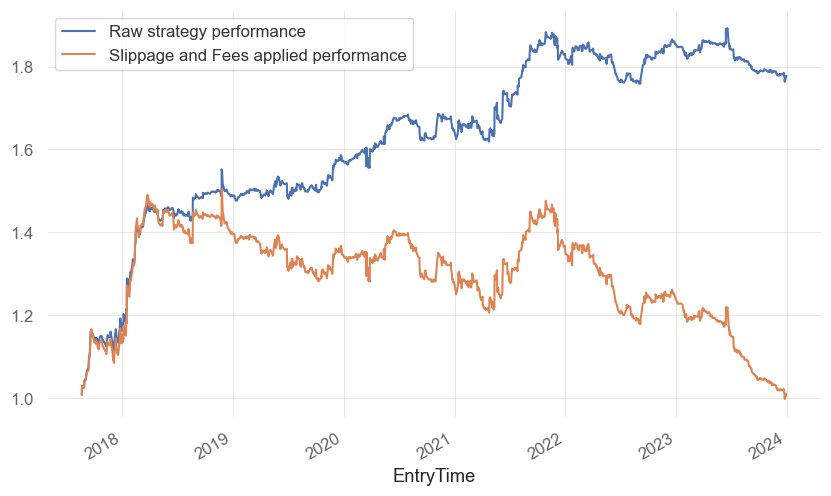

In [ ]:
#%%

position_df[['CumRet', 'CostAdjustedCumRet']].plot()
plt.legend(['Raw strategy performance', 'Slippage and Fees applied performance'])

In [ ]:
#%%

position_df['Account Change'] = position_df['CostAdjustedCumRet'].pct_change()

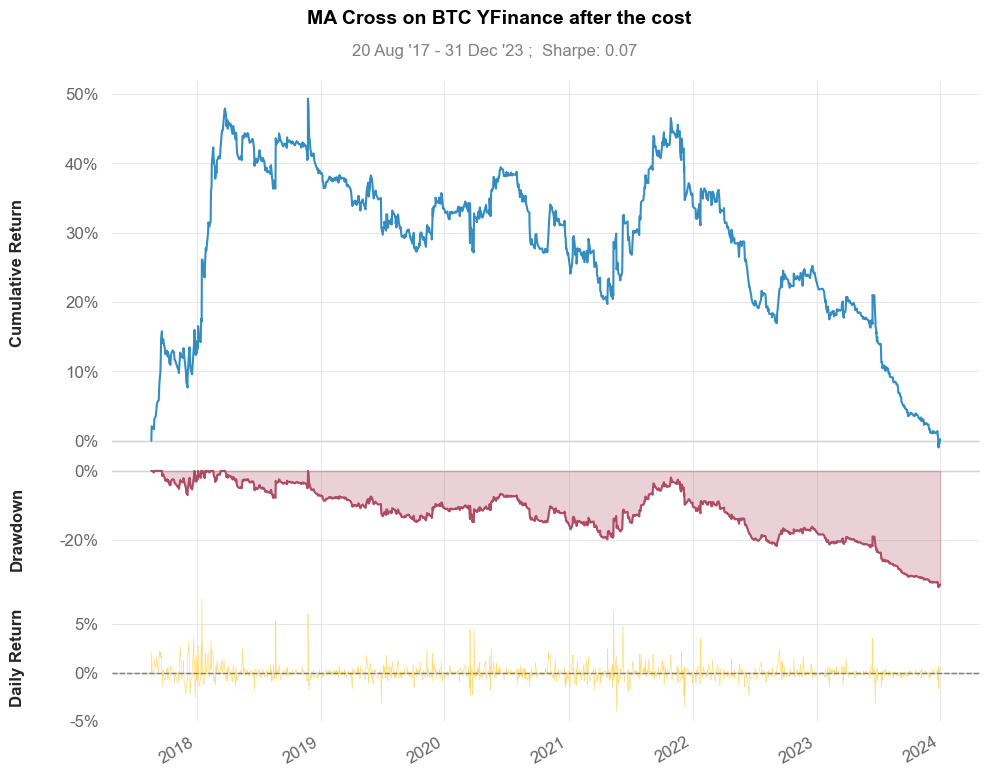

In [ ]:
#%%

qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC YFinance after the cost', show=True);

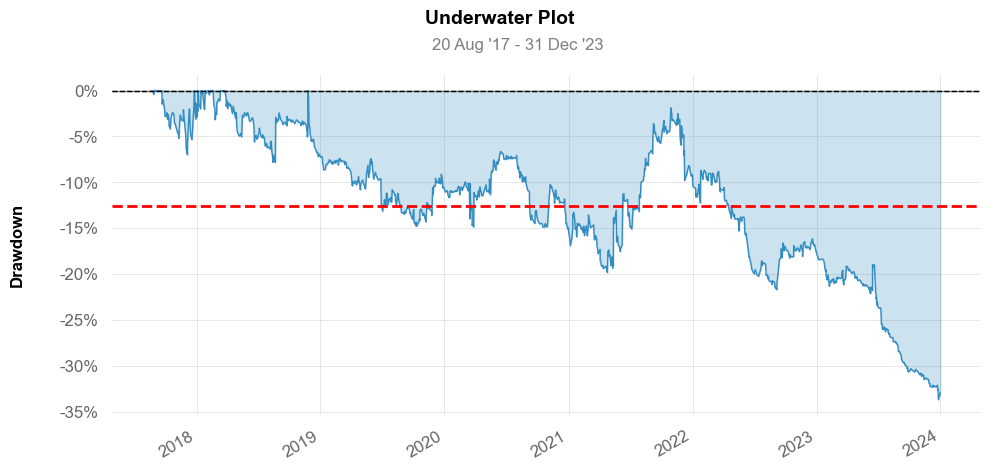

In [ ]:
#%%

qs.plots.drawdown(position_df['Account Change'])

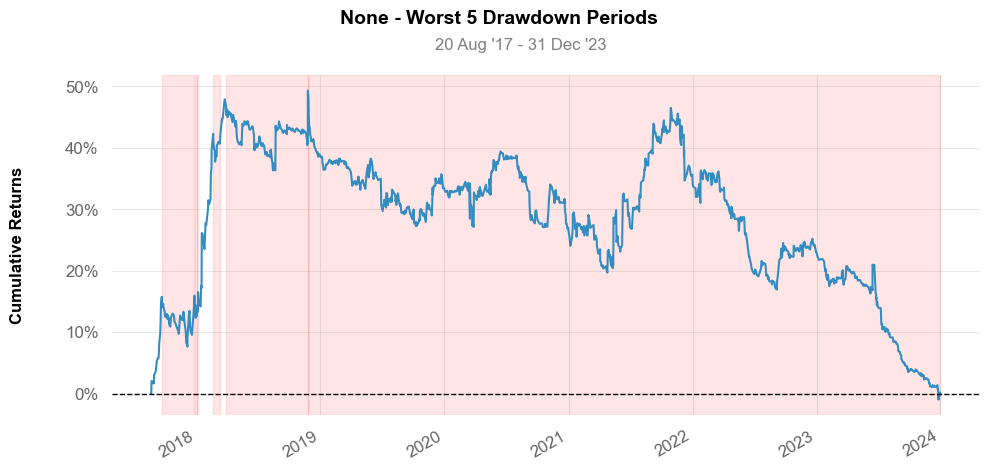

In [ ]:
#%%

qs.plots.drawdowns_periods(position_df['Account Change'])

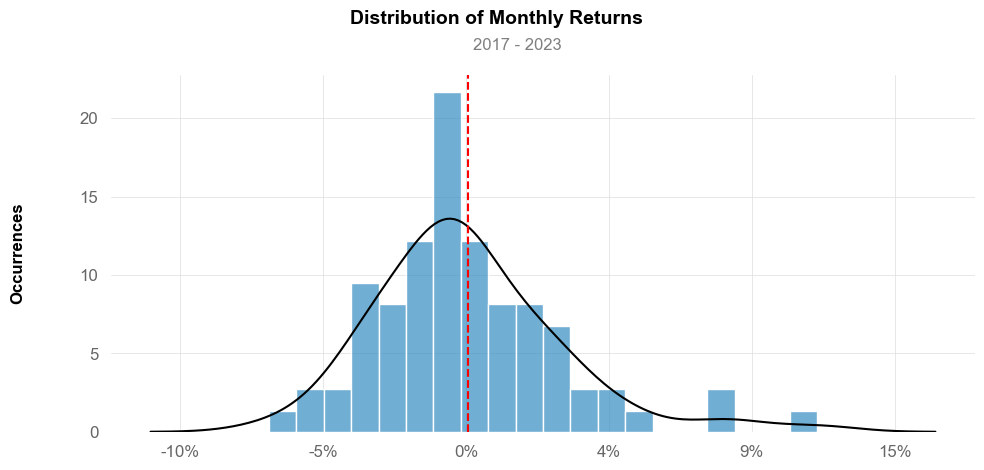

In [ ]:
#%%

qs.plots.histogram(position_df['Account Change'])

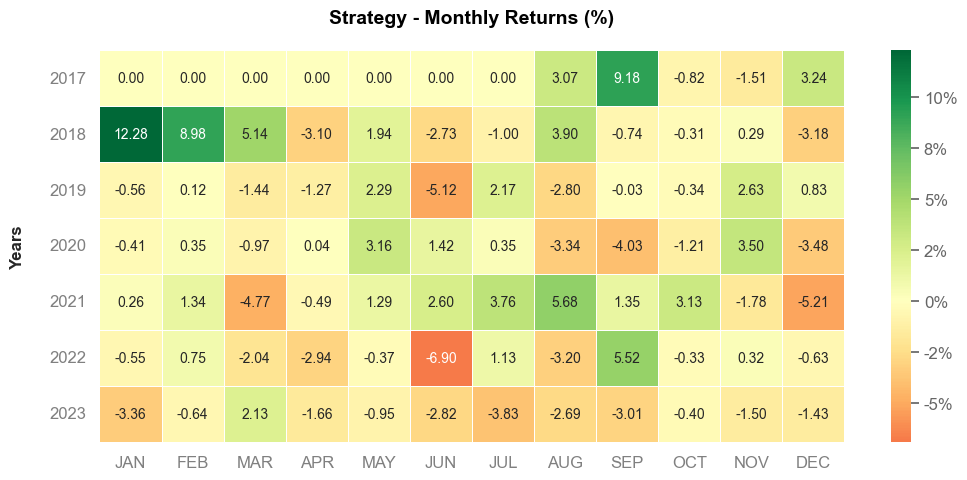

In [ ]:
#%%

qs.plots.monthly_heatmap(position_df['Account Change'])

In [ ]:
#%%

qs.stats.sharpe(position_df['Account Change'])

0.06592513568627464